In [6]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer, SimpleImputer

# Load the data
train_df = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')

# Drop data that doesn't even have sii
train_df = train_df.dropna(subset=['sii'])

# Drop columns that contain 'PCIAT', because this is not in test dataset
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='PCIAT')))]

train_df = train_df.drop(['id'], axis=1)

# Separate numerical and categorical columns
numerical_cols = train_df.select_dtypes(exclude=['object']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Impute numerical columns using KNNImputer
knn_imputer = KNNImputer()
train_df[numerical_cols] = knn_imputer.fit_transform(train_df[numerical_cols])

# Impute categorical columns using SimpleImputer with 'most_frequent' strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = categorical_imputer.fit_transform(train_df[categorical_cols])

# Encode categorical columns
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
# Sample data preparation
# Assuming `data` is your DataFrame with features and `target` is your target column
X = train_df.drop(columns=['sii'])
y = train_df['sii']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

0:	learn: 1.3182644	total: 18.4ms	remaining: 18.4s
100:	learn: 0.4560096	total: 1.39s	remaining: 12.3s
200:	learn: 0.3635698	total: 2.76s	remaining: 11s
300:	learn: 0.3072506	total: 4.14s	remaining: 9.62s
400:	learn: 0.2664444	total: 5.49s	remaining: 8.19s
500:	learn: 0.2339523	total: 6.84s	remaining: 6.81s
600:	learn: 0.2058901	total: 8.2s	remaining: 5.44s
700:	learn: 0.1841475	total: 9.56s	remaining: 4.08s
800:	learn: 0.1644917	total: 11s	remaining: 2.73s
900:	learn: 0.1482794	total: 12.4s	remaining: 1.36s
999:	learn: 0.1333337	total: 13.9s	remaining: 0us
Accuracy: 0.6131386861313869
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.87      0.78       319
         1.0       0.39      0.28      0.33       146
         2.0       0.47      0.20      0.28        76
         3.0       0.16      0.43      0.23         7

    accuracy                           0.61       548
   macro avg       0.43      0.44      0.40       548
wei

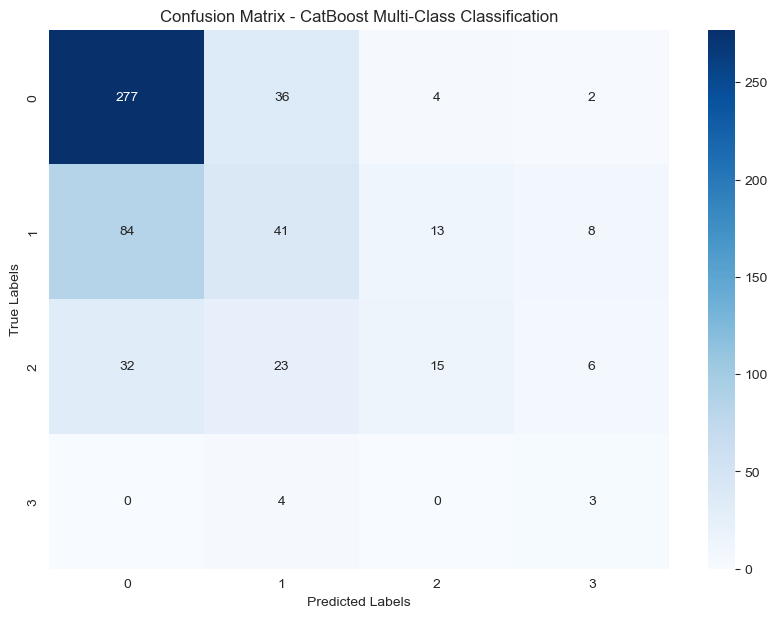

In [7]:
# Import necessary libraries
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={3: 1000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

class_weights = {0: 1, 1: 1, 2: 1, 3: 2}  # Adjust the weights according to the rarity of each class

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    loss_function='MultiClass',
    class_weights=class_weights,
    verbose=100
)


# Train the model
model.fit(X_resampled, y_resampled)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Additional metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Quadratic Weighted Kappa: {kappa}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - CatBoost Multi-Class Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

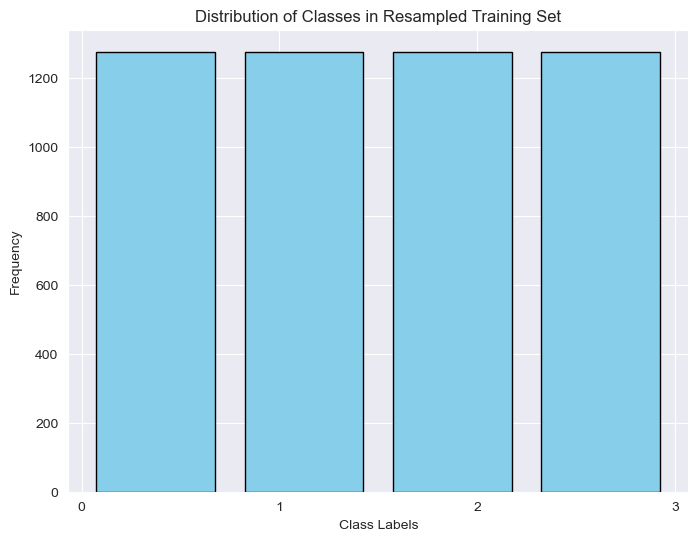

In [50]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot the histogram of the resampled target variable
plt.figure(figsize=(8, 6))
plt.hist(y_resampled, bins=len(set(y_resampled)), color='skyblue', edgecolor='black', rwidth=0.8)
plt.title('Distribution of Classes in Resampled Training Set')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(sorted(set(y_resampled)))  # Show class labels as ticks
plt.show()


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer, classification_report
from sklearn.impute import KNNImputer, SimpleImputer
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load and preprocess data
# Assuming 'train.csv' has your dataset, and 'sii' is the target column
train_df = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')

# Drop rows with missing target values
train_df = train_df.dropna(subset=['sii'])

# Drop unnecessary columns (e.g., 'id' and columns containing 'PCIAT')
train_df = train_df.drop(columns=['id'] + list(train_df.filter(regex='PCIAT').columns))

# Separate numerical and categorical columns
numerical_cols = train_df.select_dtypes(exclude=['object']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Impute missing values
knn_imputer = KNNImputer()
train_df[numerical_cols] = knn_imputer.fit_transform(train_df[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = categorical_imputer.fit_transform(train_df[categorical_cols])

# Encode categorical variables
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

# Define features and target
X = train_df.drop(columns=['sii'])
y = train_df['sii']

# Balance the dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train = X_resampled
y_train = y_resampled
# Define a custom Cohen Kappa scorer
def kappa_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Set up CatBoost parameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'class_weights': [{0: 1, 1: 1, 2: 1, 3: 1}, {0: 1, 1: 1, 2: 1, 3: 2}]
}

# Initialize CatBoost model
model = CatBoostClassifier(loss_function='MultiClass', verbose=0)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=make_scorer(kappa_scorer),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run RandomizedSearchCV
random_search.fit(X_train, y_train)

# Output best parameters and Cohen Kappa score from RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)
print("Best Cohen Kappa Score:", random_search.best_score_)

# Use the best model for predictions on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print("Test Accuracy:", accuracy)
print("Test Cohen Kappa Score:", kappa)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - CatBoost Multi-Class Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1500, 'depth': 8, 'class_weights': {0: 1, 1: 1, 2: 1, 3: 1}, 'border_count': 32}
Best Cohen Kappa Score: 0.8989690985359323
Test Accuracy: 0.5967153284671532
Test Cohen Kappa Score: 0.4088772722154064
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.81      0.76       319
         1.0       0.38      0.32      0.34       146
         2.0       0.39      0.29      0.33        76
         3.0       0.20      0.14      0.17         7

    accuracy                           0.60       548
   macro avg       0.42      0.39      0.40       548
weighted avg       0.57      0.60      0.58       548



NameError: name 'confusion_matrix' is not defined

Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1500, 'depth': 8, 'class_weights': {0: 1, 1: 1, 2: 1, 3: 1}, 'border_count': 32}
Best Cohen Kappa Score: 0.8989690985359323
Test Accuracy: 0.5967153284671532
Test Cohen Kappa Score: 0.4088772722154064
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.81      0.76       319
         1.0       0.38      0.32      0.34       146
         2.0       0.39      0.29      0.33        76
         3.0       0.20      0.14      0.17         7

    accuracy                           0.60       548
   macro avg       0.42      0.39      0.40       548
weighted avg       0.57      0.60      0.58       548



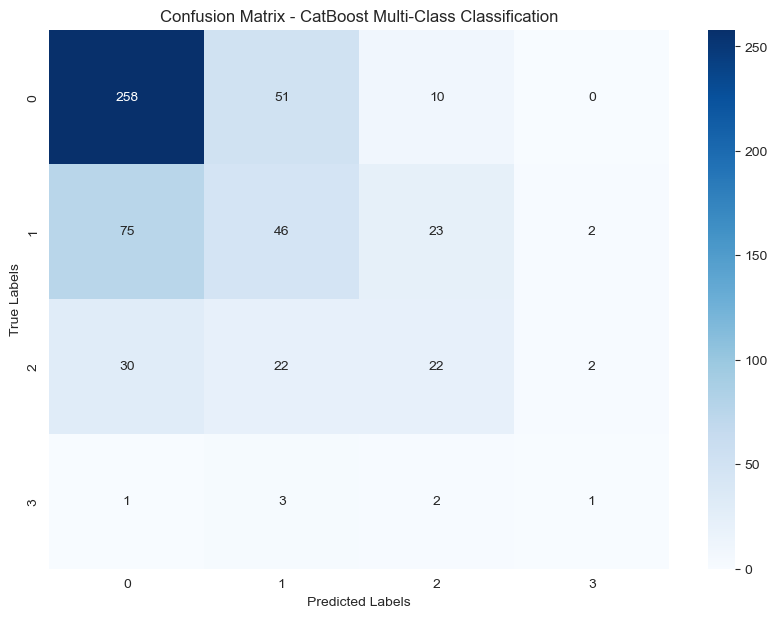

In [4]:
# Output best parameters and Cohen Kappa score from RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)
print("Best Cohen Kappa Score:", random_search.best_score_)

# Use the best model for predictions on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print("Test Accuracy:", accuracy)
print("Test Cohen Kappa Score:", kappa)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - CatBoost Multi-Class Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()